# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of 2 classes: Normal, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [31]:
import tf as tf
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import torch.nn as nn
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

# to find the index of your GPU in PyTorch:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device index: {torch.cuda.current_device()}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")

#To check if your PyTorch code has been built with GPU support, you can use the following code:

print(torch.version.cuda)  # This will print the version of CUDA used by PyTorch
print(torch.cuda.is_available())  # This will print whether PyTorch has access to a GPU
print(torch.backends.cudnn.enabled)  # This will print whether the cuDNN library is enabled for GPU acceleration

#For TensorFlow, you can use the following code to check if your code is using GPU:

print(tf.config.list_physical_devices('GPU'))  # This will print the available GPUs
print(tf.test.is_gpu_available())  # This will print whether TensorFlow has access to a GPU

Using PyTorch version 1.13.1+cpu
No GPU available, using CPU instead.
None
False
True


AttributeError: module 'tf' has no attribute 'config'

# Preparing Training and Test Sets

# Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #Verificar se o aquivo realmente é imagem 'png'
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [7]:
train_dirs = {
    'normal': 'Dataset/Normal',
    'covid': 'Dataset/COVID'
}

In [8]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 3616 normal examples
Found 3616 covid examples


In [9]:
test_dirs = {
    'normal': 'Dataset/test/Normal',
    'covid': 'Dataset/test/COVID'
}

In [10]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 covid examples


In [11]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 1206
Number of test batches 10


# Data Visualization

In [12]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

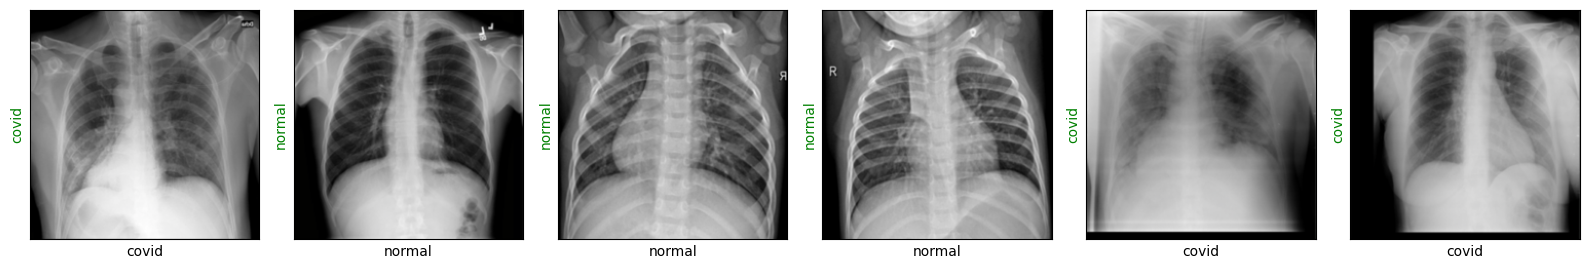

In [13]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

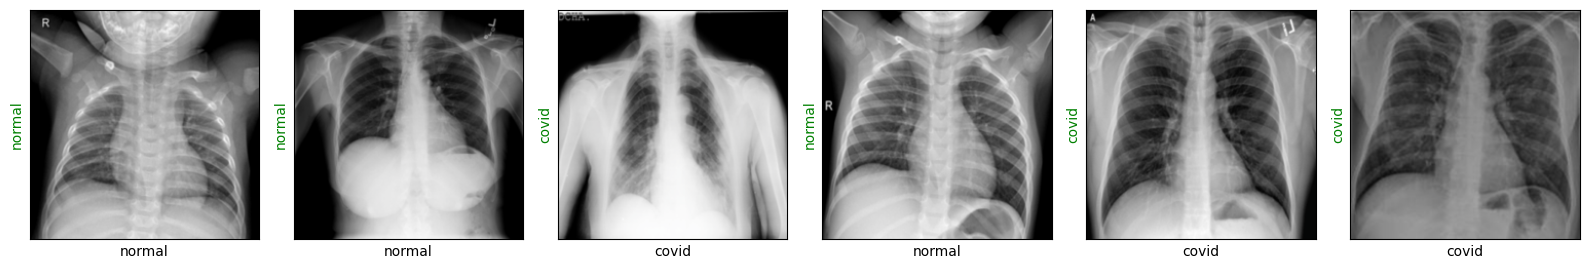

In [14]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [15]:
vgg16 = torchvision.models.vgg16(pretrained = True)

print(vgg16)

C:\Users\shorb\PycharmProjects\pythonProject\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shorb\PycharmProjects\pythonProject\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Modify the last fully connected layer to have 2 output features
num_features = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_features, 2)
# Set loss function and optimizer
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(vgg16.parameters(), lr = 3e-5)

In [17]:
def show_preds():
    vgg16.eval()
    images, labels = next(iter(dl_test))
    outputs  = vgg16(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

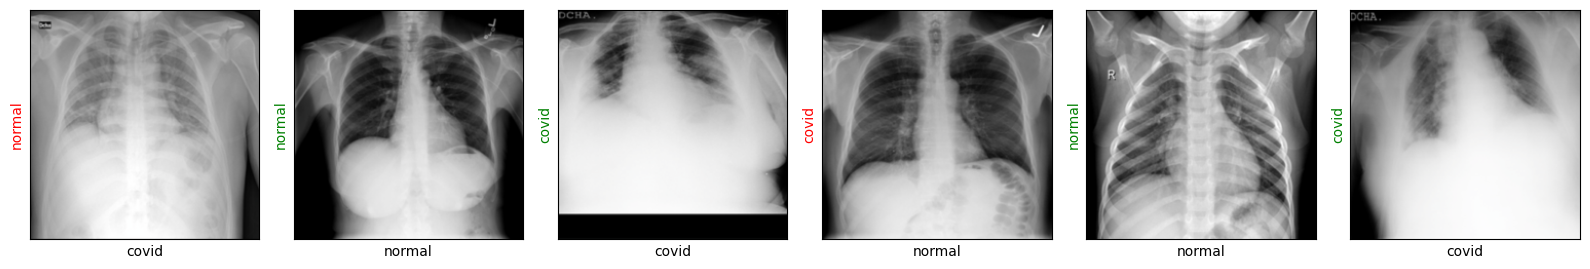

In [18]:
show_preds()

# Training the Model

In [19]:
def train(epochs):
    print('Starting training..')

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        train_acc = 0.
        val_acc = 0.

        vgg16.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = vgg16(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data).item()

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                vgg16.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = vgg16(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    val_acc += torch.sum(preds == labels.data).item()
                    accuracy += torch.sum(preds == labels.data).item()

                val_loss /= (val_step + 1)
                val_acc /= len(dl_test.dataset)
                accuracy /= len(dl_test.dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                vgg16.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)
        train_acc /= len(dl_train.dataset)

        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print('Training complete..')

    # Generate the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(train_losses, label='Training')
    ax1.plot(val_losses, label='Validation')
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(train_accs, label='Training')
    ax2.plot(val_accs, label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

    # Generate the confusion matrix and classification report
    test_preds = []
    test_labels = []
    vgg16.eval()  # set the model to evaluation mode
    for i, (images, labels) in enumerate(dl_test):
        outputs = vgg16(images)  # forward pass
        _, preds = torch.max(outputs.data, 1)
        test_preds += preds.tolist()
        test_labels += labels.tolist()

    cm = confusion_matrix(test_labels, test_preds)
    cr = classification_report(test_labels, test_preds)

    print('Confusion Matrix:\n', cm)
    print('Classification Report:\n', cr)






In [20]:
%%time

train(epochs=1)

Starting training..
Starting epoch 1/1
Evaluating at step 0


KeyboardInterrupt: 

# Final Results

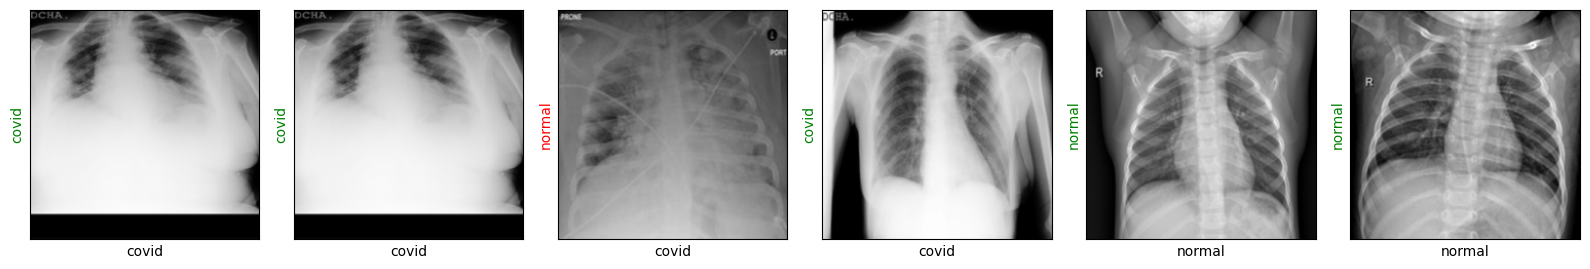

In [21]:
show_preds()
